In [2]:
# ============================================
# 셀 1: 전체 설정 (라이브러리 + 모델 + MTCNN)
# ============================================
import os
import sys
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import timm
import random
from datetime import datetime

# MTCNN Wrapper 추가
sys.path.append('../src')  # src 디렉토리를 경로에 추가
from mtcnn_wrapper import FaceDetector

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 모델 클래스 정의
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, dropout_rate=0.3):
        super(EfficientNetClassifier, self).__init__()
        self.backbone = timm.create_model(
            'efficientnet_b0', 
            pretrained=pretrained,
            num_classes=0,
            drop_rate=dropout_rate
        )
        self.feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.classifier(features)
        return outputs

# 모델 로드
def load_best_model():
    model = EfficientNetClassifier(num_classes=2, pretrained=False)
    model = model.to(device)
    
    model_path = "../results/pytorch_efficientnet/models"
    if os.path.exists(model_path):
        model_files = [f for f in os.listdir(model_path) if f.endswith('.pth')]
        if model_files:
            stage2_models = [f for f in model_files if 'stage2' in f]
            latest_model = sorted(stage2_models)[-1] if stage2_models else sorted(model_files)[-1]
            
            model_full_path = os.path.join(model_path, latest_model)
            model.load_state_dict(torch.load(model_full_path, map_location=device))
            print(f"✅ 모델 로드: {latest_model}")
        else:
            print("❌ 모델 파일을 찾을 수 없습니다.")
            return None
    else:
        print("❌ 모델 디렉토리가 존재하지 않습니다.")
        return None
    
    model.eval()
    return model

# MTCNN 얼굴 탐지기 초기화
face_detector = FaceDetector(
    image_size=224,  # EfficientNet 입력 크기에 맞춤
    margin=20,
    align_faces=True,  # 얼굴 정렬 활성화
    device=device
)

# 모델 로드
model = load_best_model()

# Transform 정의
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 클래스 설정
class_names = ['비약올리기', '약올리기']
colors = ['blue', 'red']

print("✅ 전체 설정 완료")


Device: cuda
Running on device: cuda
✅ 모델 로드: best_model_stage2_20250604_105155.pth
✅ 전체 설정 완료


In [3]:

# ============================================
# 셀 2: 통합 예측 함수 (MTCNN + 배치 처리)
# ============================================
def predict_images_with_faces(image_paths, batch_size=16):
    """
    이미지 경로들을 받아서 얼굴 탐지 + 예측을 수행
    
    Args:
        image_paths (list): 이미지 경로 리스트
        batch_size (int): 배치 크기
    
    Returns:
        list: 각 이미지별 결과 딕셔너리 리스트
    """
    if model is None:
        print("❌ 모델이 로드되지 않았습니다.")
        return []
    
    results = []
    
    for i, img_path in enumerate(image_paths):
        try:
            # 1. 원본 이미지 로드
            original_img = Image.open(img_path).convert('RGB')
            
            # 2. MTCNN으로 얼굴 탐지 및 전처리
            face_images = face_detector.process_image(original_img)
            
            if not face_images:
                # 얼굴이 감지되지 않은 경우
                results.append({
                    'file_path': img_path,
                    'file_name': os.path.basename(img_path),
                    'original_image': np.array(original_img),
                    'face_detected': False,
                    'face_image': None,
                    'prediction': None,
                    'confidence': None,
                    'probabilities': None
                })
                print(f"❌ 얼굴 미감지: {os.path.basename(img_path)}")
                continue
            
            # 3. 첫 번째 얼굴로 예측 (여러 얼굴이 있으면 첫 번째 사용)
            face_img = face_images[0]
            
            # 4. Transform 적용 및 예측
            img_tensor = test_transform(face_img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(img_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_class = torch.argmax(outputs, dim=1).item()
                confidence = probabilities[0][predicted_class].item()
            
            # 5. 결과 저장
            results.append({
                'file_path': img_path,
                'file_name': os.path.basename(img_path),
                'original_image': np.array(original_img),
                'face_detected': True,
                'face_image': np.array(face_img),
                'prediction': class_names[predicted_class],
                'predicted_class': predicted_class,
                'confidence': confidence,
                'probabilities': probabilities[0].cpu().numpy()
            })
            
            print(f"✅ {os.path.basename(img_path)}: {class_names[predicted_class]} ({confidence:.1%})")
            
        except Exception as e:
            print(f"❌ 처리 실패 {os.path.basename(img_path)}: {e}")
            results.append({
                'file_path': img_path,
                'file_name': os.path.basename(img_path),
                'original_image': None,
                'face_detected': False,
                'face_image': None,
                'prediction': None,
                'confidence': None,
                'probabilities': None
            })
    
    return results

def visualize_results(results, max_display=8):
    """
    예측 결과 시각화
    
    Args:
        results (list): predict_images_with_faces 결과
        max_display (int): 최대 표시할 이미지 수
    """
    # 유효한 결과만 필터링
    valid_results = [r for r in results if r['face_detected']]
    
    if not valid_results:
        print("❌ 표시할 유효한 결과가 없습니다.")
        return
    
    display_count = min(max_display, len(valid_results))
    cols = 4
    rows = (display_count + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    fig.suptitle(f'얼굴 탐지 + 감정 분류 결과 ({display_count}개)', fontsize=16, fontweight='bold')
    
    # axes 처리
    if display_count == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    axes = np.array(axes).flatten()
    
    for idx in range(display_count):
        result = valid_results[idx]
        
        # 얼굴 이미지 표시
        axes[idx].imshow(result['face_image'])
        axes[idx].axis('off')
        
        # 제목 설정
        pred_label = result['prediction']
        confidence = result['confidence']
        title_color = colors[result['predicted_class']]
        
        title = f"{result['file_name']}\n예측: {pred_label}\n신뢰도: {confidence:.1%}"
        axes[idx].set_title(title, fontsize=11, color=title_color, fontweight='bold')
    
    # 빈 subplot 숨기기
    for idx in range(display_count, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

def print_summary(results):
    """결과 요약 출력"""
    total = len(results)
    face_detected = len([r for r in results if r['face_detected']])
    
    print(f"\n=== 📊 처리 결과 요약 ===")
    print(f"총 이미지: {total}개")
    print(f"얼굴 감지 성공: {face_detected}개 ({face_detected/total*100:.1f}%)")
    
    if face_detected > 0:
        valid_results = [r for r in results if r['face_detected']]
        
        # 클래스별 분포
        pred_counts = {}
        for result in valid_results:
            pred = result['prediction']
            pred_counts[pred] = pred_counts.get(pred, 0) + 1
        
        for class_name, count in pred_counts.items():
            percentage = count / face_detected * 100
            print(f"{class_name}: {count}개 ({percentage:.1f}%)")
        
        # 평균 신뢰도
        avg_confidence = sum(r['confidence'] for r in valid_results) / len(valid_results)
        print(f"평균 신뢰도: {avg_confidence:.1%}")

print("✅ 통합 예측 함수 정의 완료")


✅ 통합 예측 함수 정의 완료


=== 🚀 MTCNN + 감정 분류 테스트 ===
📁 15개 이미지 발견
  단일 처리: 1개 탐지 → 1개 유효
✅ ag7.png: 약올리기 (89.1%)
  단일 처리: 1개 탐지 → 1개 유효
✅ angry_00481_0.911.jpg: 약올리기 (92.2%)
  단일 처리: 1개 탐지 → 1개 유효
✅ angry_00489_0.907.jpg: 약올리기 (88.7%)
  단일 처리: 1개 탐지 → 1개 유효
✅ angry_00529_0.967.jpg: 약올리기 (79.1%)
  단일 처리: 1개 탐지 → 1개 유효
✅ angry_02594_0.915.jpg: 약올리기 (65.2%)
  단일 처리: 2개 탐지 → 1개 유효
✅ f11.jpeg: 약올리기 (93.3%)
  단일 처리: 1개 탐지 → 1개 유효
✅ h13.png: 약올리기 (97.8%)
  단일 처리: 1개 탐지 → 1개 유효
✅ k13.png: 비약올리기 (64.3%)
  단일 처리: 1개 탐지 → 1개 유효
✅ side7.png: 약올리기 (96.1%)
  단일 처리: 1개 탐지 → 1개 유효
✅ 스크린샷 2025-05-28 154433.png: 약올리기 (92.8%)
  단일 처리: 1개 탐지 → 1개 유효
✅ 스크린샷 2025-05-30 134634_face1.png: 약올리기 (61.7%)
  단일 처리: 1개 탐지 → 1개 유효
✅ 스크린샷 2025-05-30 134634_face3.png: 약올리기 (62.1%)
  단일 처리: 1개 탐지 → 1개 유효
✅ 스크린샷 2025-05-30 134634_face7.png: 약올리기 (94.6%)
  단일 처리: 1개 탐지 → 1개 유효
✅ 스크린샷 2025-05-30 135455_face2.png: 비약올리기 (53.3%)
  단일 처리: 1개 탐지 → 1개 유효
✅ 화면 캡처 2025-05-29 103553.png: 약올리기 (99.8%)

처리 시간: 1.14초


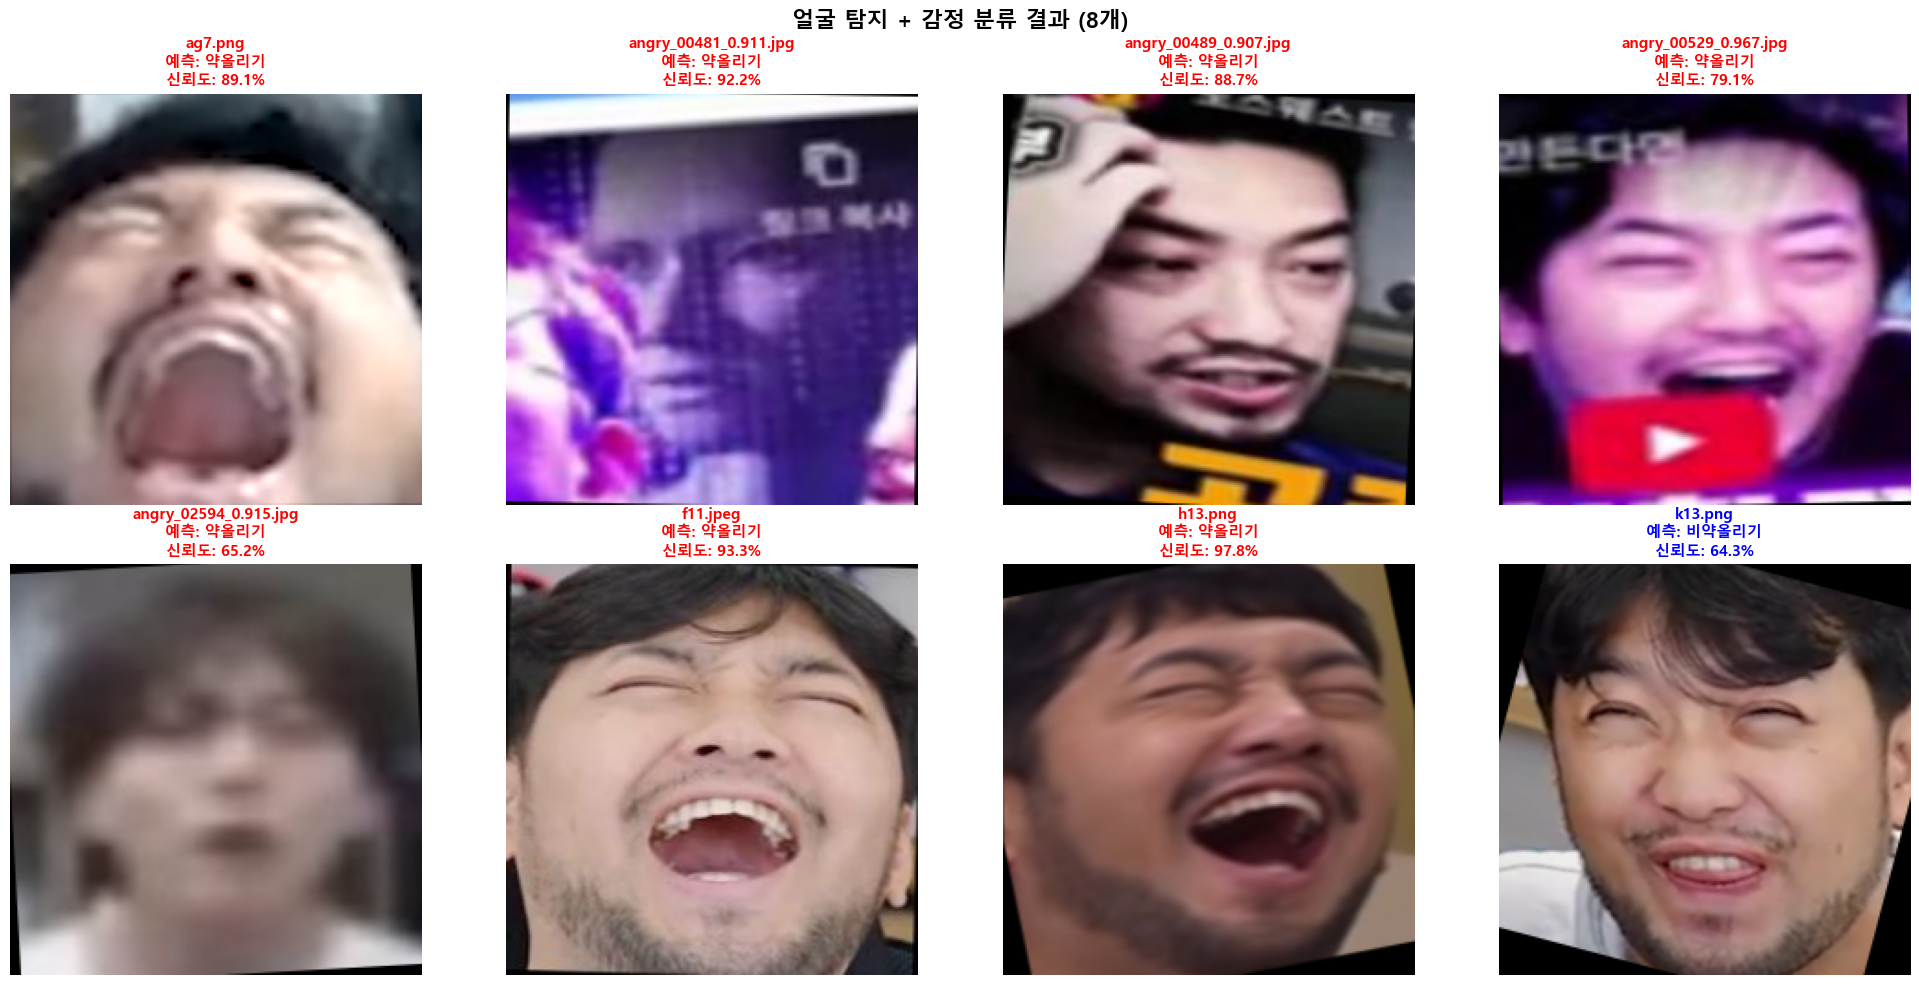


=== 📊 처리 결과 요약 ===
총 이미지: 15개
얼굴 감지 성공: 15개 (100.0%)
약올리기: 13개 (86.7%)
비약올리기: 2개 (13.3%)
평균 신뢰도: 82.0%


In [4]:

# ============================================
# 셀 3: 테스트 실행
# ============================================
# test_image 디렉토리 테스트
test_image_dir = r"D:\my_projects\calmman-facial-classification\data\processed\test_image"
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

print(f"=== 🚀 MTCNN + 감정 분류 테스트 ===")

if os.path.exists(test_image_dir):
    # 이미지 파일 목록 가져오기
    test_files = [f for f in os.listdir(test_image_dir) if f.lower().endswith(image_extensions)]
    print(f"📁 {len(test_files)}개 이미지 발견")
    
    if test_files:
        # 이미지 경로 생성
        image_paths = [os.path.join(test_image_dir, f) for f in test_files]
        
        # 처리 시작
        start_time = datetime.now()
        results = predict_images_with_faces(image_paths)
        end_time = datetime.now()
        
        processing_time = (end_time - start_time).total_seconds()
        print(f"\n처리 시간: {processing_time:.2f}초")
        
        # 결과 시각화
        visualize_results(results)
        
        # 결과 요약
        print_summary(results)
        
    else:
        print("❌ 이미지 파일이 없습니다.")
else:
    print(f"❌ 디렉토리가 존재하지 않습니다: {test_image_dir}")


In [ ]:

# ============================================
# 셀 4: 개별 이미지 상세 분석 (선택적)
# ============================================
def analyze_single_image_detailed(image_path):
    """단일 이미지 상세 분석 (원본 + 얼굴 + 확률 그래프)"""
    results = predict_images_with_faces([image_path])
    
    if not results or not results[0]['face_detected']:
        print("❌ 얼굴이 감지되지 않았습니다.")
        return
    
    result = results[0]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. 원본 이미지
    axes[0].imshow(result['original_image'])
    axes[0].set_title('원본 이미지', fontsize=14)
    axes[0].axis('off')
    
    # 2. 감지된 얼굴
    axes[1].imshow(result['face_image'])
    axes[1].set_title(f'감지된 얼굴 (MTCNN 정렬)', fontsize=14)
    axes[1].axis('off')
    
    # 3. 확률 막대 그래프
    probs = result['probabilities']
    bars = axes[2].bar(class_names, probs, color=['lightblue', 'lightcoral'])
    bars[result['predicted_class']].set_color(colors[result['predicted_class']])
    
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('확률')
    axes[2].set_title(f'예측: {result["prediction"]} ({result["confidence"]:.1%})', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    
    # 확률 값 표시
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("✅ 개별 분석 함수 정의 완료")
print("\n사용법:")
print("analyze_single_image_detailed('이미지_경로')")

# 예시 실행 (첫 번째 이미지가 있는 경우)
if 'test_files' in locals() and test_files:
    first_image_path = os.path.join(test_image_dir, test_files[0])
    print(f"\n=== 첫 번째 이미지 상세 분석: {test_files[0]} ===")
    analyze_single_image_detailed(first_image_path)